In [1]:
import sys

sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain")
sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain\\source")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.loftr.backbone import ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange
from torchvision.transforms import v2
from source.data_processing.image_reading import read_image
from torchvision.transforms import ToTensor
from source.data_processing.keypoints import translate_patch_midpoints_and_refine
import matplotlib.pyplot as plt
import numpy as np
from source.miscellaneous.evaluation import load_deformation
from source.visualization.image_visualization import plot_images_with_keypoint_matches
from kornia.geometry.ransac import RANSAC
from source.data_processing.cropping import crop_image

In [3]:
matches = torch.load(f"../../models/coarse_matching/8/matches.pt")
deformation = load_deformation()
image_1 = read_image("../../data/cyto_downscaled_3344_3904_evaluation/B20_0524_Slice15.tif")
image_2 = read_image("../../data/cyto_downscaled_3344_3904_evaluation/B20_0525_Slice15.tif")
image_1, image_2 = ToTensor()(image_1), ToTensor()(image_2)

image_1, image_2 = v2.Normalize(mean=[0.594], std=[0.204])(image_1), v2.Normalize(mean=[0.594], std=[0.204])(image_2)

In [4]:
matches.shape

torch.Size([8127, 4])

In [5]:
image_1_visualization_adjusted = torch.concatenate((image_1, torch.zeros(1, 8000, 205)), dim=2)
image_2_visualization_adjusted = torch.concatenate((image_2, torch.zeros(1, 618, 3668)), dim=1)

In [6]:
image_1_visualization_adjusted.shape, image_2_visualization_adjusted.shape

(torch.Size([1, 8000, 3667]), torch.Size([1, 8000, 3668]))

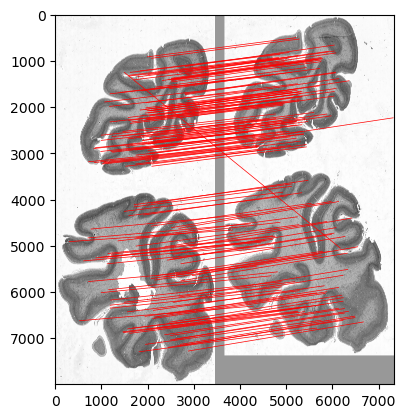

In [7]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches[::50, :2], 
                                  matches[::50, 2:],)

In [8]:
from sklearn.cluster import DBSCAN

# Assuming `matches` is your tensor of shape [N, 4]
matches_np = matches.numpy()  # Convert to NumPy array if it's a tensor

# Apply DBSCAN clustering
# Adjust `eps` according to your definition of "too close"
# `min_samples=1` allows for clusters of a single point
clustering = DBSCAN(eps=10, min_samples=2).fit(matches_np)

# Iterate through the clusters and keep one match from each
matches_dbscan = []
for cluster_id in np.unique(clustering.labels_):
    cluster_indices = np.where(clustering.labels_ == cluster_id)[0]
    # Here, we simply take the first match in the cluster
    # You could also consider other criteria like taking the centroid, etc.
    unique_match = matches_np[cluster_indices[0]]
    matches_dbscan.append(unique_match)

# Convert back to tensor if needed
matches_dbscan = torch.tensor(matches_dbscan)

print(f"Original number of matches: {len(matches_np)}")
print(f"Filtered number of matches: {len(matches_dbscan)}")


Original number of matches: 8127
Filtered number of matches: 1432


C:\Users\robin\AppData\Local\Temp\ipykernel_8312\1239454541.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  matches_dbscan = torch.tensor(matches_dbscan)


In [9]:
matches_dbscan.shape

torch.Size([1432, 4])

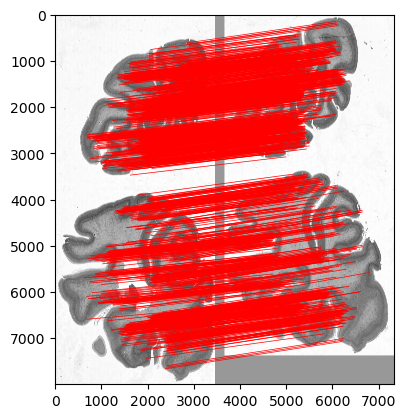

In [10]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches_dbscan[:, :2], 
                                  matches_dbscan[:, 2:],)

In [23]:
ransac = RANSAC(inl_th=17, confidence=0.2)
# print(crop_1_patch_mid_coordinates.shape, crop_2_patch_mid_coordinates_refined.shape)
M, inliers = ransac(matches[:, :2], matches[:, 2:])
matches_ransac = matches[inliers]
matches_ransac.shape

torch.Size([1500, 4])

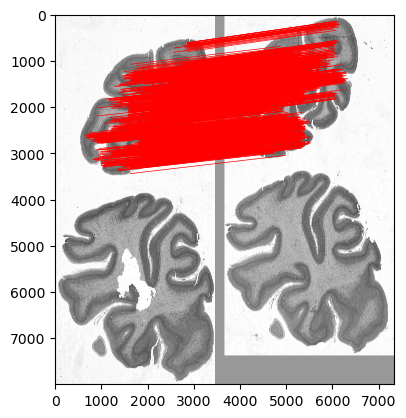

In [22]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches_ransac[:, :2], 
                                  matches_ransac[:, 2:],)

In [19]:
matches_dbscan.shape, matches_ransac.shape

(torch.Size([1432, 4]), torch.Size([1403, 4]))

In [14]:
from source.miscellaneous.evaluation import evaluate_test_image_pair

In [15]:
(
    number_of_matches_ransac,
    average_distance_ransac,
    match_precision_ransac,
    auc_ransac,
    matches_per_patch_ransac,
    entropy_ransac,
) = evaluate_test_image_pair(matches_ransac[:, :2], matches_ransac[:, 2:], deformation)

(
    number_of_matches_dbscan,
    average_distance_dbscan,
    match_precision_dbscan,
    auc_dbscan,
    matches_per_patch_dbscan,
    entropy_dbscan,
) = evaluate_test_image_pair(matches_dbscan[:, :2], matches_dbscan[:, 2:], deformation)

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:93: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1


In [16]:
number_of_matches_ransac, average_distance_ransac, auc_ransac, entropy_ransac

(1485, 3.4190971851348877, 6.571710404542973, 8.546855926513672)

In [17]:
number_of_matches_dbscan, average_distance_dbscan, auc_dbscan, entropy_dbscan

(1432, 5.756141662597656, 4.844944133885438, 9.068684577941895)